# Predicting uncertainties on measured bandpowers 

This notebook shows you how to predict the errors on auto-correlation and cross-correlation bandpowers.

You need to install this Python package (orphics), which should be achievable with a simple pip command as shown in README.md.

Apart from that, the only non-trivial dependency (other than things like scipy, matplotlib, etc.) is the Python wrapper for CAMB.

On most systems with gcc 4.9+, you can install pycamb with:
```
pip install camb --user
```

See https://camb.readthedocs.io/en/latest/ for details.

In [7]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from orphics import cosmology,io
import numpy as np
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# First initialize a cosmology object with default params
lc = cosmology.LimberCosmology(lmax=3000,pickling=True)

Generating theory Cls...
Loaded cached Cls from  output/clsAll_3000_20171220.pkl
Loaded cached Cls from  output/clphi_3000_20171220.txt
Initializing CMB window..
initializing power...


('Initializing galaxy window for ', 'g', ' ...')


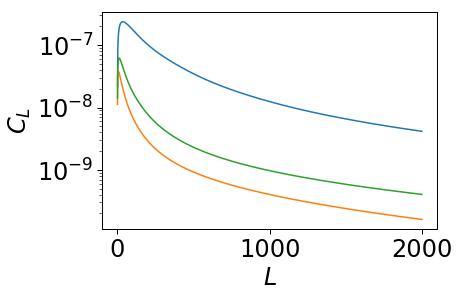

In [10]:
# Let's define a mock dndz
def dndz(z):
    z0 = 1./3.
    ans = (z**2.)* np.exp(-1.0*z/z0)/ (2.*z0**3.)
    return ans    

z_edges = np.arange(0.,3.0,0.1)
zcents = (z_edges[1:]+z_edges[:-1])/2.
# Let's add this dndz to the cosmology object. By default, LimberCosmology doesn't allow you to reuse tag names, but here we force it to since this is a Python notebook!
lc.addNz(tag="g",zedges=z_edges,nz=dndz(zcents),ignore_exists=True)
ellrange = np.arange(0,2000,1)
# And generate the bandpower predictions
lc.generateCls(ellrange)
clkk = lc.getCl("cmb","cmb")
clkg = lc.getCl("cmb","g")
clgg = lc.getCl("g","g")

pl = io.Plotter(yscale='log',ylabel='$C_L$',xlabel='$L$')
pl.add(ellrange,clkk)
pl.add(ellrange,clgg)
pl.add(ellrange,clkg)
pl.done()


Let's do a forecast for the errors on the measured bandpowers. Errors are determined by:

- Sample variance (which is just given by the power-spectra of the fields) -- $C_L^{kk}$, $C_L^{ss}$, $C_L^{ks}$
- Measurement noise $N_L^{kk}$,$N_L^{ss}$
- Fraction of sky measured  $f_{\mathrm{sky}}$

Given these, we can predict the S/N of the amplitude of the measurement of any of $C_L^{kk}$, $C_L^{ss}$, $C_L^{ks}$ and the error bars on binned bandpowers.

We will assume for now that the galaxy survey has 20 galaxies per arcminute square, and the CMB lensing survey has no noise. This sets a lower bound on the measurement noise contribution when an HSC-like survey is cross-correlated with a CMB lensing map.

Expected S/N : 24.4653784766


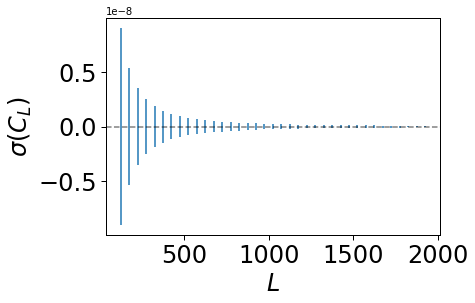

In [11]:
# Initialize a simple lens forecaster

Nlkk = clkk*0. # Assume no noise in CMB lensing map
lf = cosmology.LensForecast()
lf.loadKK(ellrange,clkk,ellrange,Nlkk)
lf.loadKS(ellrange,clkg)
lf.loadSS(ellrange,clgg,ngal=20.)


ell_edges = np.arange(100,2000,50) # define some broad L bins
ells = (ell_edges[:-1]+ell_edges[1:])/2.
fsky = 40./41250. #0.05

# Get S/N and errors
sn,errs = lf.sn(ell_edges,fsky,"ks")

print("Expected S/N :",sn)

pl = io.Plotter(xlabel='$L$',ylabel='$\sigma(C_L)$')
pl.add_err(ells,ells*0.,yerr=errs)
pl.hline()
pl.done()



## Is sample cross-covariance important?

The above error bars had contributions from sample variance and measurement noise in the galaxy survey. Often, a CMB survey has a set of mocks (which captures $C_L^{kk}$ and $N_L^{kk}$ contributions) and a galaxy survey has an independent set of mocks (which captures $C_L^{ss}$ and $N_L^{ss}$). Since they are independently produced, cross-correlations between the mocks will capture everything except the $C_L^{ks}$ term. Is this term  important?

We can check this by calculating theory errors with and without the sample covariance term. To do this, we just set ```clkg``` to zero. Note that this will predict zero S/N, but that's OK, we just need to check the effect on the error bars. 

Expected S/N : 0.0


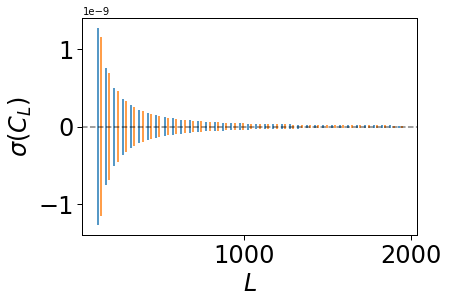

In [5]:
lf2 = cosmology.LensForecast()
lf2.loadKK(ellrange,clkk,ellrange,clkk*0.)
lf2.loadKS(ellrange,clkg*0.)
lf2.loadSS(ellrange,clgg,ngal=20.)

sn2,errs2 = lf2.sn(ell_edges,fsky,"ks")

print("Expected S/N :",sn2)

pl = io.Plotter(xlabel='$L$',ylabel='$\sigma(C_L)$')
pl.add_err(ells,ells*0.,yerr=errs)
pl.add_err(ells+20,ells*0.,yerr=errs2)
pl.hline()
pl.done()


What impact does this have on error bars?

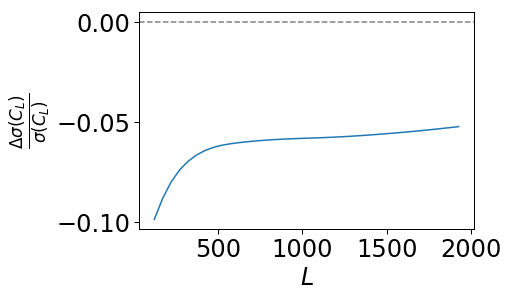

In [6]:

pl = io.Plotter(xlabel='$L$',ylabel='$\\frac{\\Delta \\sigma(C_L)}{\\sigma(C_L)}$')
pl.add(ells,(errs2-errs)/errs)
pl.hline()
pl.done()

Looks like it's not more than 10%! That's good, underestimating the errorbars by 10% isn't a huge deal for a a measurement that is already 10%. Note that this was for *no noise in the CMB lensing map* which is very far from true, even for a futuristic CMB Stage 4 experiment. For a realistic analysis, there will be so much noise in the CMB lensing map that the effect of sample cross-covariance should be even less. Redoing the above with a typical Nlkk curve is left as an exercise :)